In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_and_ztrans\Hao_Harmony_test_no_scale.h5ad")
adata.shape

(161764, 33538)

In [3]:
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')

label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print(types)

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [6]:
# Briefly view adata.X (raw counts)
rows, cols = adata.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.4895154535770416
Row 0, Column 43, Value 0.8167138695716858
Row 0, Column 48, Value 0.8167138695716858
Row 0, Column 53, Value 0.8167138695716858
Row 0, Column 55, Value 1.424944519996643
Row 0, Column 66, Value 0.4895154535770416
Row 0, Column 77, Value 0.8167138695716858
Row 0, Column 78, Value 1.424944519996643
Row 0, Column 89, Value 0.8167138695716858
Row 0, Column 93, Value 1.0628387928009033
Row 0, Column 102, Value 0.8167138695716858
Row 0, Column 154, Value 2.4626553058624268
Row 0, Column 178, Value 0.8167138695716858
Row 0, Column 185, Value 0.4895154535770416
Row 0, Column 190, Value 0.4895154535770416
Row 0, Column 201, Value 1.8004224300384521
Row 0, Column 224, Value 0.8167138695716858
Row 0, Column 240, Value 0.4895154535770416
Row 0, Column 259, Value 0.4895154535770416
Row 0, Column 261, Value 1.566353440284729


## Scale genes

In [7]:
# Scale each gene to unit variance
sc.pp.scale(adata)

## Read features

In [4]:
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans_v2\Level1\feature_selection")

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [5]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,17,16
CD4_T,1719,813
CD8_T,7,5
DC,1250,579
Mono,73,65
NK,232,127
other,380,205
other_T,1097,568


## Get likelihood from LR model

In [12]:
def LR_likelihood_decision_score(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    decision_scores = clf.decision_function(X)  # >0: predict celltype, <0: predict not celltype
    print('decision_scores > 0:', sum(decision_scores > 0))

    # calculate the likelihood of the positive class for each observation in X based on the decision scores
    likelihood = 1 / (1 + np.exp(-decision_scores))
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype
    print(type(likelihood), likelihood.shape)
    #do the row-wise softmax
    # likelihood = np.exp(likelihood)/np.sum(np.exp(likelihood),1,keepdims=True)
    
    return likelihood


def LR_likelihood_pred_prob(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # likelihood of the positive class for each observation
    likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個

    return likelihood


In [13]:
celltype = 'B'
B_likelihood = LR_likelihood_pred_prob(adata, features_dict, celltype)
B_likelihood.shape

Celltype: B
likelihood > 0.5: 13763


(161764,)

In [16]:
B_likelihood[:5]

array([9.35793514e-06, 2.56421385e-05, 1.54474889e-05, 2.16310921e-05,
       1.53430261e-05])

In [17]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood_pred_prob(adata, features_dict, celltype)

Celltype: B
likelihood > 0.5: 13763
Celltype: CD4_T
likelihood > 0.5: 41060
Celltype: CD8_T
likelihood > 0.5: 23819
Celltype: DC
likelihood > 0.5: 3578
Celltype: Mono
likelihood > 0.5: 49535
Celltype: NK
likelihood > 0.5: 18650
Celltype: other
likelihood > 0.5: 2855
Celltype: other_T
likelihood > 0.5: 6505


In [18]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,0.000009,6.263078e-10,0.002446,2.417709e-07,0.980386,1.339573e-06,0.000603,9.865340e-08
1,0.000026,9.999997e-01,0.031708,2.667327e-09,0.000097,8.716102e-06,0.001953,6.994405e-06
2,0.000015,9.403794e-09,0.999187,7.532286e-12,0.000083,3.535960e-07,0.000844,4.720462e-03
3,0.000022,1.913660e-11,0.006413,9.397976e-13,0.000016,9.999936e-01,0.002015,1.550197e-04
4,0.000015,1.262106e-10,0.998388,7.244680e-14,0.000066,1.424636e-06,0.003514,1.750332e-03


In [19]:
likelihood_df.shape

(161764, 8)

In [20]:
# row sum
likelihood_df.sum(axis=1)


0         0.983446
1         1.033800
2         1.004850
3         1.008614
4         1.003736
            ...   
161759    0.983000
161760    1.005598
161761    1.004515
161762    0.988887
161763    0.998143
Length: 161764, dtype: float64

In [22]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans_v2\Level1\LR_likelihood")
likelihood_df.to_csv('L1_likelihood_df.csv')

## (1st_type / 2nd_type) >= 1.5

In [ ]:
largest_values = []
second_largest_values = []
largest_columns = []
second_largest_columns = []
odds_ratio_list = []
assignments = []

# for index, row in likelihood_softmax.iterrows():
for index, row in likelihood_df.iterrows():
    # find 1st and 2nd largest values and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    second_largest_value = row.nlargest(2).iloc[-1]
    second_largest_column = row.nlargest(2).index[-1]
    
    largest_values.append(largest_value)
    second_largest_values.append(second_largest_value)
    largest_columns.append(largest_column)
    second_largest_columns.append(second_largest_column)

    # calculate odds ratio
    odds_ratio = largest_value / second_largest_value
    if odds_ratio >= 1.5:
        assign = largest_column
    else:
        assign = 'Uncertain'
    odds_ratio_list.append(odds_ratio)
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns,
                          'Second Largest Value': second_largest_values, 'Second Largest Column': second_largest_columns, 
                          'Odds Ratio': odds_ratio_list, 'Assignment': assignments})
result_df.shape


In [ ]:
result_df.head(20)

In [ ]:
sum(result_df['Assignment'] == 'Uncertain')

In [ ]:
12915/len(result_df)

## Assign the celltype with the largest likelihood (no odds ratio)

In [23]:
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
result_df.shape


(161764, 3)

In [24]:
result_df.head(20)

,Largest Value,Largest Column,Assignment
0,0.980386,Mono,Mono
1,1.000000,CD4_T,CD4_T
2,0.999187,CD8_T,CD8_T
3,0.999994,NK,NK
4,0.998388,CD8_T,CD8_T
5,0.437113,CD8_T,CD8_T
6,0.991715,Mono,Mono
7,0.999947,B,B
8,1.000000,NK,NK
9,0.999624,CD8_T,CD8_T


In [25]:
# count 'uncertain'
sum(result_df['Assignment'] == 'Uncertain')

0

## Confusion heatmap

In [26]:
import pandas as pd

# Get the true labels
true_labels = adata.obs['celltype.l1'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
# cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [27]:
cm

Predicted,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
True,,,,,,,,
B,13780,1,4,0,7,3,5,0
CD4_T,1,40786,137,0,3,6,2,66
CD8_T,2,544,24427,0,3,66,7,420
DC,1,1,0,3550,35,0,2,0
Mono,7,7,9,23,48888,2,74,0
NK,0,14,50,0,0,18570,1,29
other,9,73,39,1,489,30,2784,17
other_T,3,103,425,0,2,44,1,6211


In [29]:
cm.to_csv('likelihood_assignment_confusion_matrix.csv')

## Plot confusion matrix

In [2]:
os.chdir('./LR_likelihood')
cm = pd.read_csv('likelihood_assignment_confusion_matrix.csv', index_col=0)

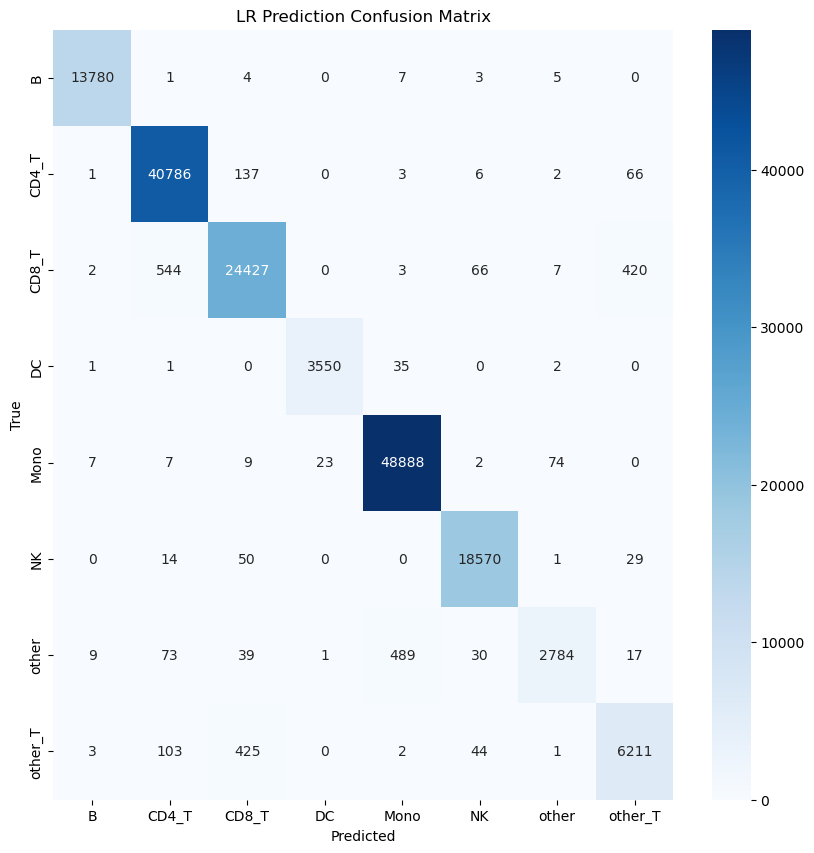

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [4]:
row_sum = cm.sum(axis=1)
row_sum


True
B          13800
CD4_T      41001
CD8_T      25469
DC          3589
Mono       49010
NK         18664
other       3442
other_T     6789
dtype: int64

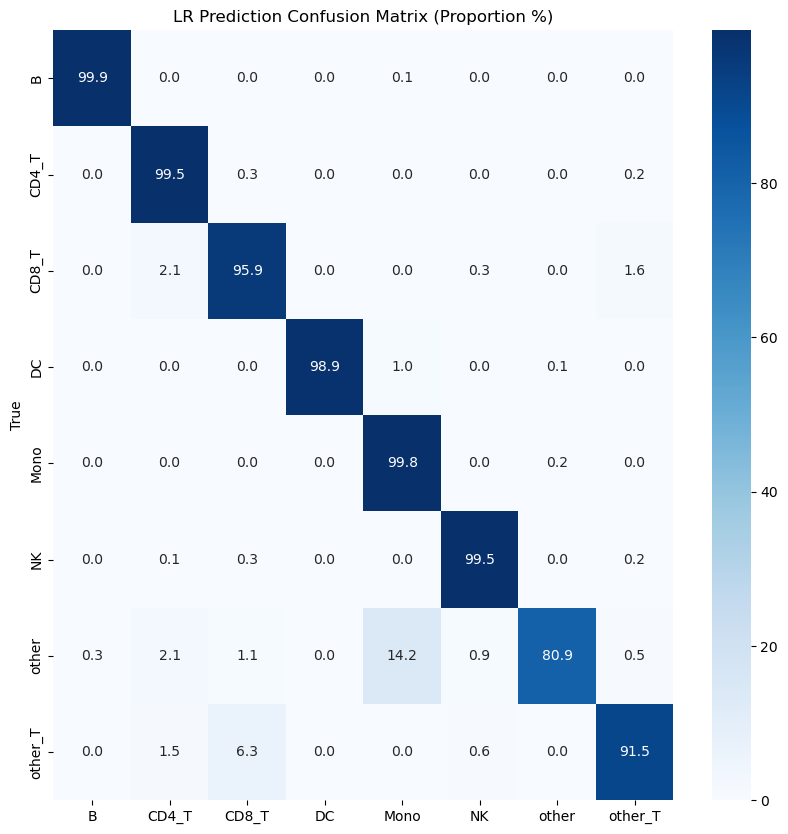

In [5]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(10, 10))
sns.heatmap(cm_proportion, fmt=".1f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.savefig('cm_plot.png', dpi=300)
plt.show()

## Calculate accuracy

In [6]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.9828886526050296

In [7]:
cm.values.sum()

161764